# Analyse et Preprocessing des données

## Objectif

L'objectif de ce notebook est de reprendre les données déjà concaténées en un seul fichier et y faire un peu de feature engineering après avoir fait un split pertinent training/validation/test. 

## Import des libraries

In [12]:
import os  # for path dirs and files

# to deal with data
import numpy as np
import pandas as pd

# plot the results
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## Récupération des données

In [13]:
df = pd.read_csv(os.path.join('.', 'data', 'data_full.csv'))  # read file
df = df.dropna()                                              # delete days with Nan values
df['day'] = pd.to_datetime(df['day'])                         # convert the str days to dates
df

,pair,day,open,high,low,close
15,AUDCAD,2007-10-22,0.8620,0.8700,0.8607,0.8686
16,AUDCAD,2007-10-23,0.8685,0.8736,0.8606,0.8720
17,AUDCAD,2007-10-24,0.8719,0.8768,0.8672,0.8742
18,AUDCAD,2007-10-25,0.8741,0.8804,0.8715,0.8793
19,AUDCAD,2007-10-26,0.8792,0.8842,0.8755,0.8840
...,...,...,...,...,...,...
225252,ZARJPY,2020-12-25,7.0670,7.0680,6.9760,7.0540
225253,ZARJPY,2020-12-28,7.1000,7.1150,7.0550,7.0860
225254,ZARJPY,2020-12-29,7.0850,7.1080,7.0160,7.0360
225255,ZARJPY,2020-12-30,7.0370,7.0750,7.0010,7.0510


## Distribution temporelle des données

Ce que l'on veut savoir maintenant c'est la distribution temporelles des données. Autrement dit, il est nécessaire d'avoir un apperçu des plages de date pour chaque paire de devise pour lesquelles on a l'historique des valeurs (peu importe les valeurs pour le moment).

In [14]:
group_df = df.groupby('pair').agg({           # for each pair...
    'day':['min', 'max']                      # ... we want to get its time range of existing history.
}).reset_index().sort_values(('day', 'min'))  # Sorting the pair by day they appear for an easy use and visualization

group_df

pair        day           
                  min        max
24  EURUSD 2000-05-30 2020-12-31
45  USDCHF 2000-05-30 2020-12-31
50  USDJPY 2000-05-30 2020-12-31
31  GBPUSD 2000-05-30 2020-12-31
4   AUDUSD 2000-06-05 2020-12-31
..     ...        ...        ...
10  ETXEUR 2010-11-15 2019-02-01
6   BCOUSD 2010-11-15 2020-12-31
5   AUXAUD 2010-11-15 2020-12-30
46  USDCZK 2010-11-15 2020-12-31
65  ZARJPY 2010-11-15 2020-12-31

[66 rows x 3 columns]

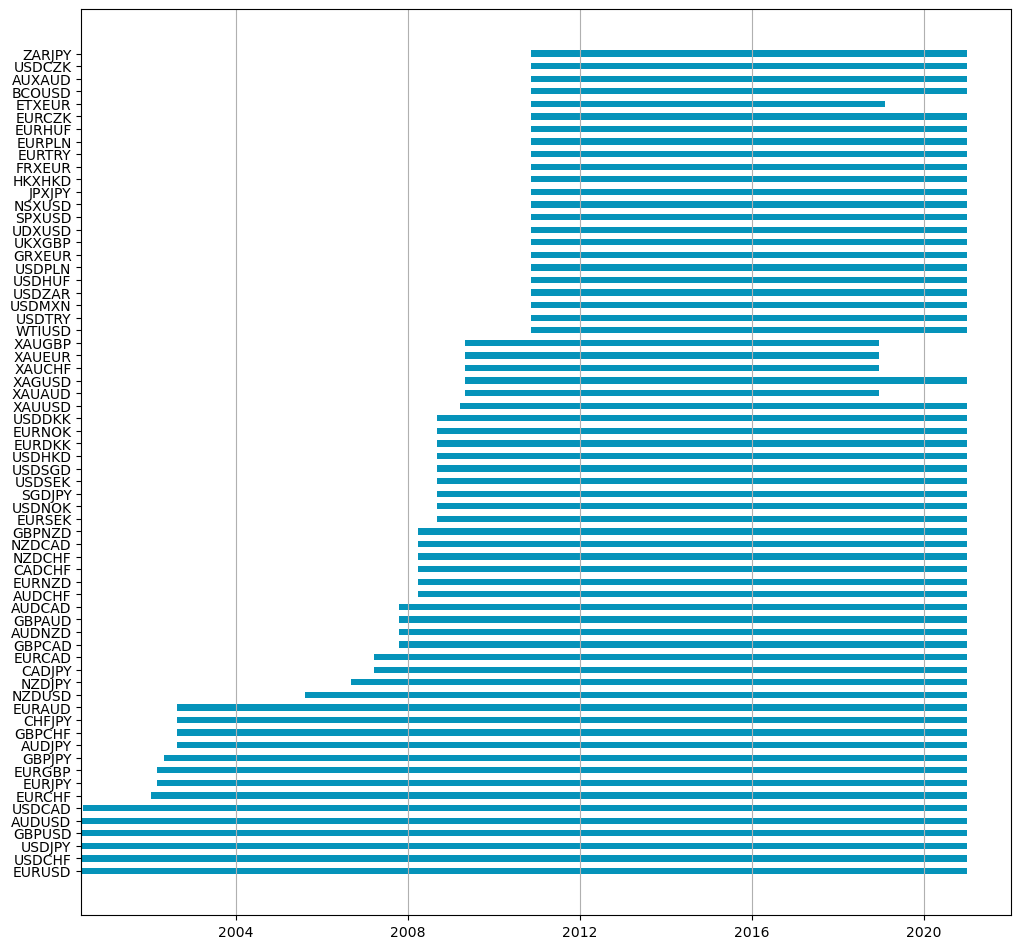

In [15]:
plt.rcParams['figure.figsize'] = [12, 12]


# convert df columns to list 
min_date = group_df[('day', 'min')].tolist()
max_date = group_df[('day', 'max')].tolist()
pair = group_df['pair'].tolist()

# convert time to Matplotlib number format
max_date, min_date = [matplotlib.dates.date2num(item) for item in (max_date, min_date)]
time_diff = max_date - min_date

# ypos is given by they order in min date as we have sorted it before
ypos = range(len(pair))  

# we can now plot the bars of existing history of values for each pair
fig, ax = plt.subplots()
ax.barh(ypos, time_diff, left=min_date, height=0.5, align='center', color='#0593ba')
plt.yticks(ypos, pair)

# better visualization
ax.axis('tight')  
ax.xaxis_date()
plt.gca().xaxis.grid(True)
plt.show()

plt.rcParams['figure.figsize'] = [12, 4]


In [16]:
pair[:10]

['EURUSD',
 'USDCHF',
 'USDJPY',
 'GBPUSD',
 'AUDUSD',
 'USDCAD',
 'EURCHF',
 'EURJPY',
 'EURGBP',
 'GBPJPY']

## Création des différents jeux de donnée

EUR/USD, USD/JPY, GBP/USD, AUD/USD et USD/CAD sont les 5 paires les plus tradées. 
On considèrera ces paires comme étant notre jeu d'entrainement. 

Ensuite on considèrera les 5 paires avec le plus d'historique exceptées les 5 du jeu d'entrainement comme étant partie du jeu d'entrainement. Autrement dit, il s'agit des paires 



In [17]:
training_pairs = [
    'EURUSD',
    'USDJPY',
    'GBPUSD',
    'AUDUSD',
    'USDCAD'    
]
validation_pairs = [
    'USDCHF',
    'EURCHF',
    'EURJPY',
    'EURGBP',
    'GBPJPY'
]

In [18]:
N_LOOK_BACK_INPUT = 240 + 1  # (+1 because of the return calculation giving a first Nan value)

On donne un nombre à chaque couple (paire de devise, jour) correspondant à son rang depuis le début de la série temporelle de la devise en question.

In [19]:
# count the rank of the day from the beginning of the temporal serie
df['count'] = df.groupby('pair').cumcount()

# create a function to define the set of the row according to the rank of the day (pair-independant)
def get_set(row):
    
    modulo_count = row['count'] % cum_total
    
    if row['count'] < N_LOOK_BACK_INPUT:
        return 'unpredictable'
    elif row['pair'] in training_pairs:
        return 'training'
    elif row['pair'] in validation_pairs:
        return 'validation'
    else:
        return 'test'
        
# count the rank of the set from the beginning of the temporal serie
# circle of unpredictable --> training --> training --> training --|
#                                 ^                                |
#                                 |--------------------------------|
df['set'] = df.apply(get_set, axis=1)
df['set_group'] = (df.set != df.set.shift(1)).cumsum()


# now we don't want to have the data by pair but pair couple of pair and set of data
group_df = df.groupby(['pair', 'set_group', 'set']).agg({
    'day':['min', 'max'],
}).reset_index().sort_values(('day', 'min'))
group_df

pair set_group            set        day           
                                            min        max
62   GBPUSD        63  unpredictable 2000-05-30 2001-05-01
90   USDCHF        91  unpredictable 2000-05-30 2001-05-01
48   EURUSD        49  unpredictable 2000-05-30 2001-05-01
100  USDJPY       101  unpredictable 2000-05-30 2001-05-01
8    AUDUSD         9  unpredictable 2000-06-05 2001-05-07
..      ...       ...            ...        ...        ...
87   UKXGBP        88           test 2011-10-18 2020-12-31
93   USDCZK        94           test 2011-10-18 2020-12-31
99   USDHUF       100           test 2011-10-18 2020-12-31
67   HKXHKD        68           test 2011-10-18 2020-12-30
131  ZARJPY       132           test 2011-10-18 2020-12-31

[132 rows x 5 columns]

Et on affiche le résultat pour l'examiner

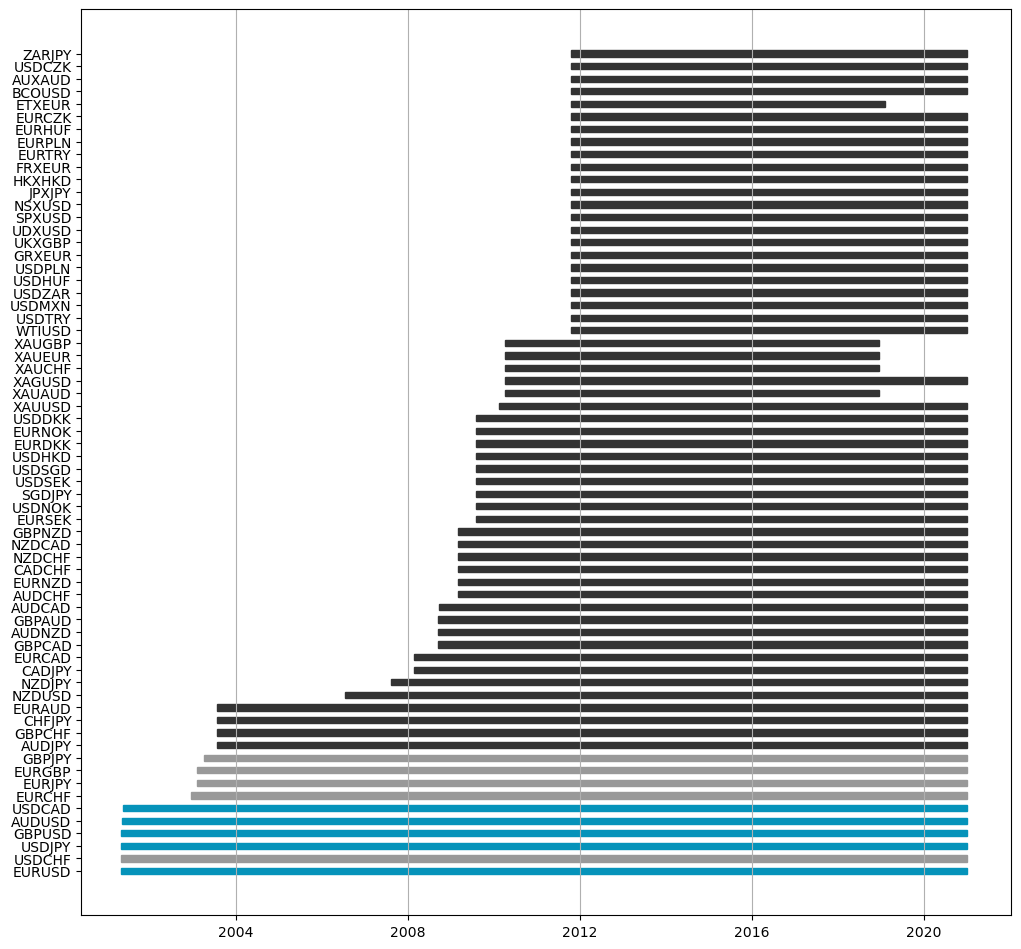

In [21]:
plt.rcParams['figure.figsize'] = [12, 12]


# convert df columns to list 
min_date = group_df[('day', 'min')].tolist()
max_date = group_df[('day', 'max')].tolist()
pairs = group_df['pair'].tolist()



# ypos is given by the pair order in min date as we have sorted it before
unique_pair = df.groupby('pair').day.min().reset_index().sort_values('day').pair
pair_to_y = {pair:count for count, pair in enumerate(unique_pair)}
ypos = [pair_to_y[pair] for pair in pairs]

# set a different color to each hbar showing the different sets
set_name = group_df['set'].tolist()
set_name_to_color = {'unpredictable': '#ffffff', 'training': '#0593ba', 'validation': '#999999', 'test': '#333333'}
color = [set_name_to_color[name] for name in set_name]

# convert time to Matplotlib number format
max_date, min_date = [matplotlib.dates.date2num(item) for item in (max_date, min_date)]
time_diff = max_date - min_date

# we can now plot the bars of existing history of values for each pair
fig, ax = plt.subplots()
ax.barh(ypos, time_diff, left=min_date, height=0.5, align='center', color=color, edgecolor=color)
plt.yticks(range(len(unique_pair)), unique_pair)

# better visualization
ax.axis('tight')
ax.xaxis_date()
plt.gca().xaxis.grid(True)
plt.show()

plt.rcParams['figure.figsize'] = [12, 4]


## Distributions des valeurs des données

### DataViz

Maintenant que nous avons bien partagé les données en 3 set training/validation/test, il est intéressant de savoir comment sont distribuées les données. 

Pour cela, affichons les historiques des devises au cours du temps sur un mettre graphique. 

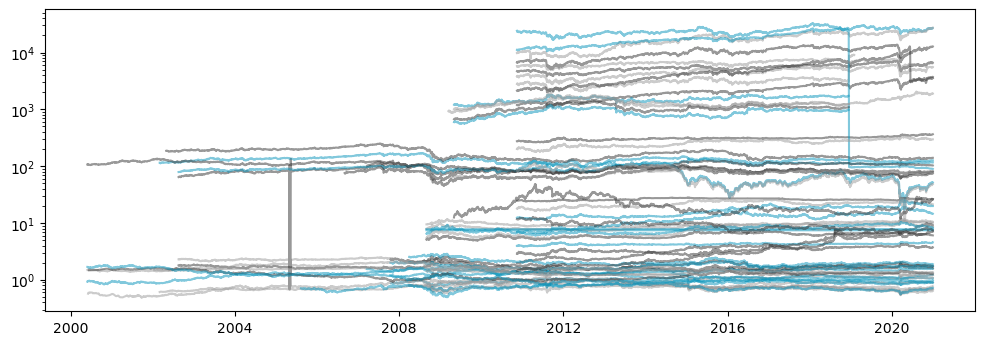

In [22]:
# alternate colors only for dataviz esthetic
colors = ['#0593ba', '#999999', '#333333']

# for each pair, plot its history 
# (no matter what pair it is, we only want to see the distributions between pairs)
for i, (pair, pair_group) in enumerate(df.groupby('pair')):
    color = colors[i % len(colors)]
    plt.plot(pair_group.day, pair_group.open, color=color, alpha=0.5)
    
# log scale on y axis to have all the different values in a better view
plt.yscale('log')


On peut constater qu'il y a une énorme disparité entre les valeurs absolues des devises. 

Ceci implique que les paires de devise l'une en rapport à l'autre ont un ratio qui va approximativement de l'ordre 1 à 10.000

Mais le graphique n'est pas le meilleur qu'on puisse faire. 
En effet, on peut faire un meilleur graphique représentant la distribution cumulative de toutes les valeurs des paires de devises contenues dans le dataset.

**Pour cette distribution cumulative, on affichera toutes les valeurs sauf les epsilon%=1% des valeurs extrêmes**.  
Autrement dit, si on ordonne toutes les valeurs de 1 à 100 % triées par leur valeur, alors on affiche les valeurs appartenant à l'intervalle [0+epsilon/2,100-EPSILON/2] soit [0.5%, 99.5%].

0.6083 1037.2735437235824 3426.753044051865 24805.0


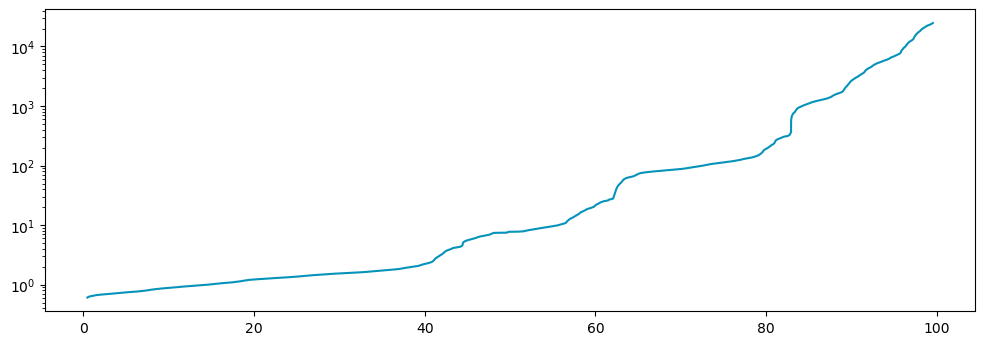

In [23]:
EPSILON = 1

# we sort the values ascendently 
# and give them their corresponding value equaly distributed from 0 to 100
y = df.sort_values('open')['open']
x = np.linspace(0, 100, len(y))

# we remove the epsilon extrems values to avoid unusable graph 
# and according more details to the common values
percent = EPSILON / 2
idx_percent = int(len(y) * percent / 100)
x, y, = x[idx_percent:-idx_percent], y[idx_percent:-idx_percent]

# now we can plot these values 
plt.plot(x, y, color='#0593ba')
plt.yscale('log')
print(y.min(), y.mean(), y.std(), y.max())
pass

On peut donc clairement constater notre supposition. En effet, les données sont distribuées de façon logarthmiques. Donc on pourrait logiquement appliquer une fonction log sur les donnée mais ce serait contre productif.

### Feature engineering

Avec un peu de connsaissance métier, il est pertinent de ne plus prendre en compte les valeurs des paires de devise de façon brute, mais d'opter pour un ratio de retour. 

$R_{t} = \frac{R_{t} - R_{t-1}}{R_{t-1}} = \frac{R_{t}}{R_{t-1}} - 1 $

In [24]:
df['return'] = df.open / df.open.shift(1) - 1 
df = df.dropna()  # to remove the first value (that's why we put N_LOOK_BACK_INPUT = 240 before)
df

,pair,day,open,high,low,close,count,set,set_group,return
16,AUDCAD,2007-10-23,0.8685,0.8736,0.8606,0.8720,1,unpredictable,1,0.007541
17,AUDCAD,2007-10-24,0.8719,0.8768,0.8672,0.8742,2,unpredictable,1,0.003915
18,AUDCAD,2007-10-25,0.8741,0.8804,0.8715,0.8793,3,unpredictable,1,0.002523
19,AUDCAD,2007-10-26,0.8792,0.8842,0.8755,0.8840,4,unpredictable,1,0.005835
20,AUDCAD,2007-10-29,0.8862,0.8899,0.8751,0.8770,5,unpredictable,1,0.007962
...,...,...,...,...,...,...,...,...,...,...
225252,ZARJPY,2020-12-25,7.0670,7.0680,6.9760,7.0540,2639,test,132,-0.002822
225253,ZARJPY,2020-12-28,7.1000,7.1150,7.0550,7.0860,2640,test,132,0.004670
225254,ZARJPY,2020-12-29,7.0850,7.1080,7.0160,7.0360,2641,test,132,-0.002113
225255,ZARJPY,2020-12-30,7.0370,7.0750,7.0010,7.0510,2642,test,132,-0.006775


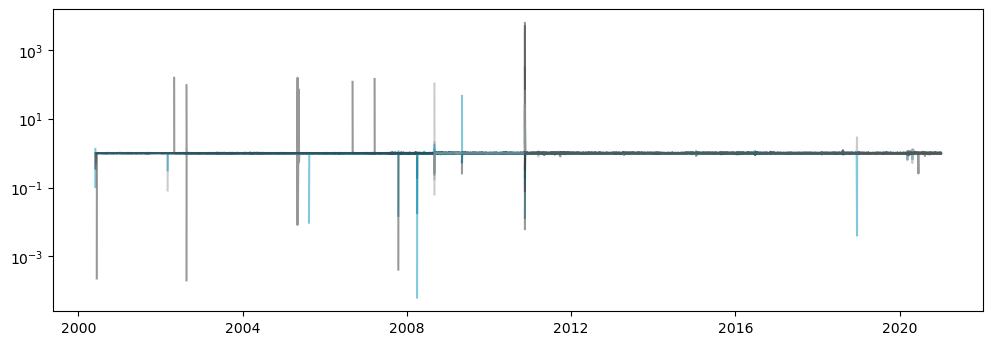

In [25]:
colors = ['#0593ba', '#999999', '#333333']

for i, (pair, pair_group) in enumerate(df.groupby('pair')):
    color = colors[i % len(colors)]
    plt.plot(pair_group.day, pair_group['return'] + 1, color=color, alpha=0.5)
plt.yscale('log')


On peut maintenant voir que toutes les coubres se superposent et vraisemblablement autour de 0 ce qui est bon signe. D'autant plus que cela implique qu'il n'y aura pas de biais entres les différentes devises qui seront traitées de la même façon. 

Mais, encore une fois, le graphique n'est pas le meilleur qu'on puisse faire. En effet, on peut faire un meilleur graphique représentant la distribution cumulative de toutes les valeurs des paires de devises contenues dans le dataset.

-0.031394913447968076 9.834573436604173e-05 0.007112246597765839 0.030224778449439604


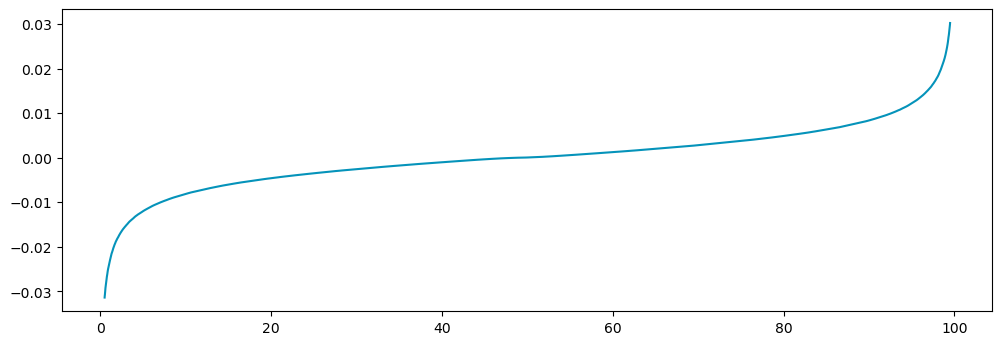

In [26]:
y = df.sort_values('return')['return']
x = np.linspace(0, 100, len(y))

percent = 1 / 2
idx_percent = int(len(y) * percent / 100)

x, y, = x[idx_percent:-idx_percent], y[idx_percent:-idx_percent]
plt.plot(x, y, color='#0593ba')
print(y.min(), y.mean(), y.std(), y.max())

pass

Effectivement, on remarque que les données sont bien réparties autour de zéro. Même mieux, on a une répartition symétrique.

Vérifions tout cela avec un histogramme (pour ceux qui n'auraient pas le coup d'oeil avec ce graphique)

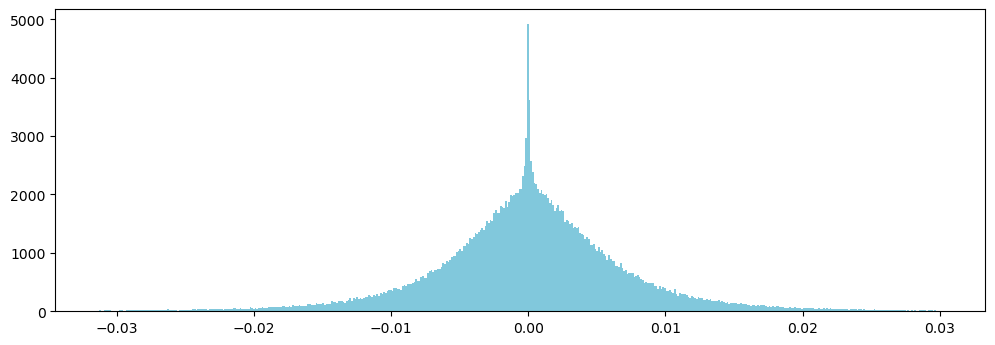

In [27]:
plt.hist(y, bins=500, color='#0593ba', alpha=0.5)
pass

On peut donc garder les colonnes utiles et sauvegarder le tout

In [28]:
df = df[['pair', 'day', 'return', 'set']]
df

,pair,day,return,set
16,AUDCAD,2007-10-23,0.007541,unpredictable
17,AUDCAD,2007-10-24,0.003915,unpredictable
18,AUDCAD,2007-10-25,0.002523,unpredictable
19,AUDCAD,2007-10-26,0.005835,unpredictable
20,AUDCAD,2007-10-29,0.007962,unpredictable
...,...,...,...,...
225252,ZARJPY,2020-12-25,-0.002822,test
225253,ZARJPY,2020-12-28,0.004670,test
225254,ZARJPY,2020-12-29,-0.002113,test
225255,ZARJPY,2020-12-30,-0.006775,test


In [29]:
df.to_csv(os.path.join('.', 'data', 'data_full_preprocessed.csv'), index=False)
